In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px
from IPython.display import display
from bokeh.plotting import figure, output_notebook, show, output_file, save
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin
from bokeh.layouts import row, column
from bokeh.io import push_notebook
import os
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoTokenizer
import torch
from collections import defaultdict
from sklearn.manifold import TSNE

In [2]:
train.head()

,Question,Response,target
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3


In [5]:
train.head(3).to_dict()

{'Question': {0: 'Explain the concept of coevolution.',
  1: 'Is it possible that recurring fever and chills could indicate malaria?',
  2: 'Evaluate the expression 3!'},
 'Response': {0: "Coevolution is a biological process that occurs when two or more species evolve together over time. This means that each species changes in response to changes in the other, leading to a close and often complex relationship between them. \n\nFor example, the process of coevolution can be observed in the relationship between plants and pollinators like bees and butterflies. As flowers evolve to attract specific types of insects for pollination (for example, by changing their scent or the shape of their petals), those insects in turn evolve traits that make them better at reaching and collecting nectar from those flowers (like longer tongues or specialized eye structures).\n\nCoevolution can also involve a predator and its prey, where each species adapts to counteract the other's adaptation. For instan

In [6]:
test.head()

,Question,Response
id,,
0,Multiply 13 by 7.,Multiplying 13 by 7 gives a result of 64.\nThe...
1,Who were the main protagonists in the Hundred ...,The most important characters in this war incl...
2,What was the importance of the Truman Doctrine?,"The Truman Doctrine, also known as the United ..."
3,Which film features a character named Jack Ske...,The Nightmare Before Christmas
4,What are the components of the cytoskeleton?,"The cytoskeleton, which provides the framework..."


In [7]:
print("-"*20+"Train"+"-"*20)
display(train.Question.describe())
print("")
display(train.Response.describe())
print("")
print("-"*20+"Test"+"-"*20)
display(test.Question.describe())
print("")
display(test.Response.describe())

--------------------Train--------------------


count                                    3976
unique                                    568
top       Explain the concept of coevolution.
freq                                        7
Name: Question, dtype: object

count           3969
unique          3968
top       __________
freq               2
Name: Response, dtype: object


--------------------Test--------------------


count                  1001
unique                  143
top       Multiply 13 by 7.
freq                      7
Name: Question, dtype: object

count                                                   999
unique                                                  999
top       Multiplying 13 by 7 gives a result of 64.\nThe...
freq                                                      1
Name: Response, dtype: object

In [8]:
train.fillna("*",inplace=True)
test.fillna("*",inplace=True)
def count_string(x):
    return len(x.split())
train["word_count_q"]= train.Question.apply(count_string)
test["word_count_q"]=test.Question.apply(count_string)
train["word_count_r"]= train.Response.apply(count_string)
test["word_count_r"]=test.Response.apply(count_string)

<Figure size 1296x576 with 0 Axes>

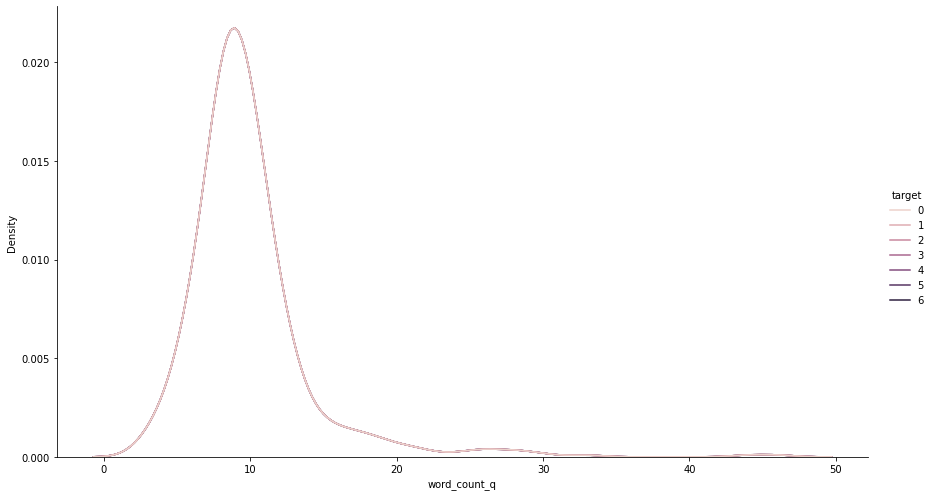

In [10]:
plt.figure(figsize=(18,8))
sns.displot(data=train, x="word_count_q",hue="target",height=7, aspect=1.77,kind="kde")

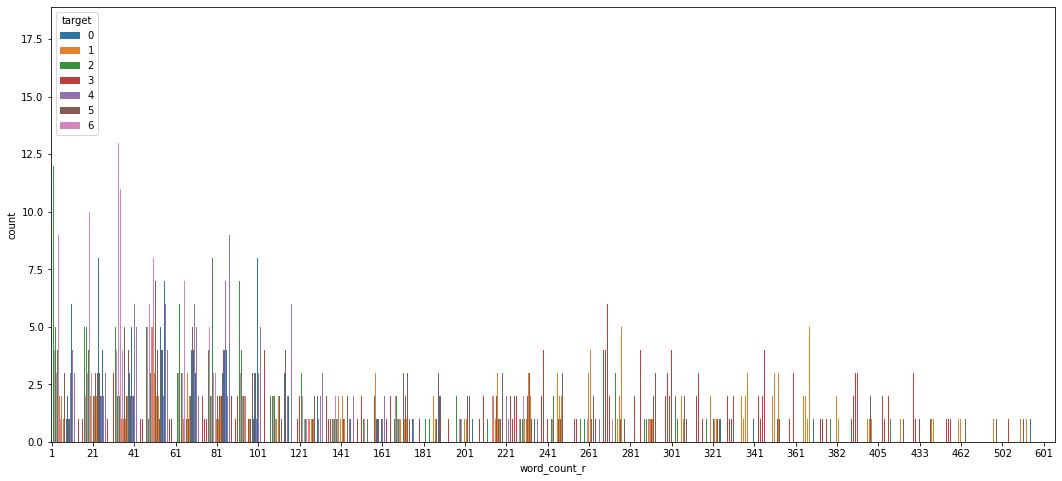

In [11]:
plt.figure(figsize=(18,8))
sns.countplot(data=train, x="word_count_r",hue="target")
plt.xticks(list(range(0,500,20)));

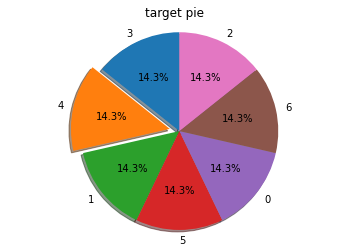

3    568
4    568
1    568
5    568
0    568
6    568
2    568
Name: target, dtype: int64


In [13]:
def pieplot(df, col, title, explodeplace=0):
    """
    Create a pie chart from a DataFrame column.

    Args:
        df (DataFrame): The DataFrame containing the data.
        col (str): The name of the column to plot.
        title (str): Title for the pie chart.
        explodeplace (int): Index of the segment to explode (default: 0).

    Returns:
        None
    """
    value_counts = df[col].value_counts()
    explode = np.zeros(len(value_counts))
    explode[explodeplace] = 0.1

    plt.pie(value_counts, explode=explode, labels=value_counts.index, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.title(title)
    plt.show()
    print(value_counts)
pieplot(train,"target","target pie",explodeplace=1)

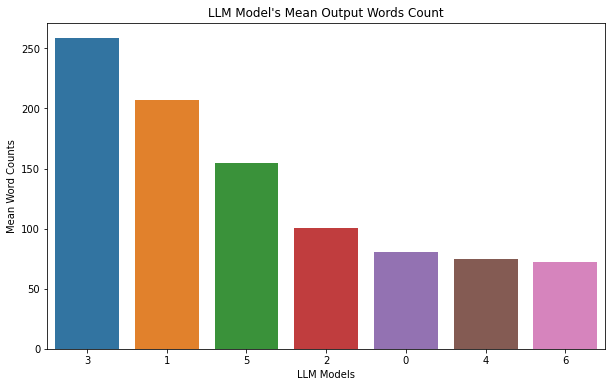

In [16]:
aggregation = train.groupby("target")["word_count_r"].mean()
plt.figure(figsize=(10,6))
sns.barplot(x=aggregation.index,y=aggregation.values,
           order=aggregation.sort_values(ascending=False).index)
plt.ylabel("Mean Word Counts")
plt.xlabel("LLM Models")
plt.title("LLM Model's Mean Output Words Count")
plt.show();

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(set(stopwords.words('english')));

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Basic Summary:
                                   Question
count                                  3976
unique                                  568
top     Explain the concept of coevolution.
freq                                      7
Most Common Words:
what: 1603 times
who: 476 times
how: 329 times
explain: 322 times
describe: 301 times
can: 287 times
i: 266 times
concept: 231 times
could: 203 times
cause: 168 times


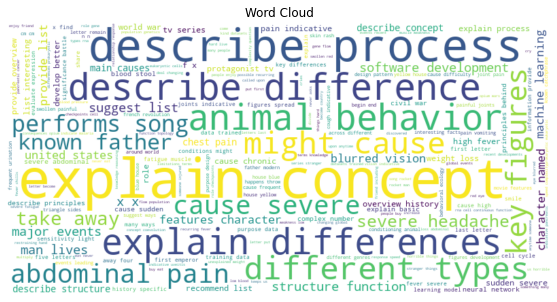

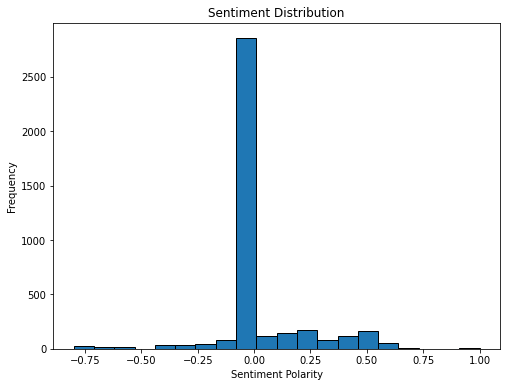


Basic Summary:
       Response
count      3976
unique     3969
top           *
freq          7
Most Common Words:
the: 4557 times
this: 2545 times
data: 1859 times
it: 1535 times
a: 1266 times
i: 1252 times
also: 1177 times
in: 1154 times
process: 1075 times
like: 1041 times


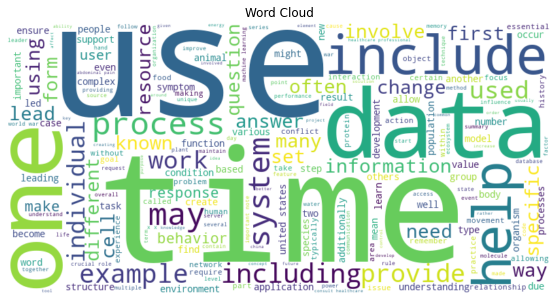

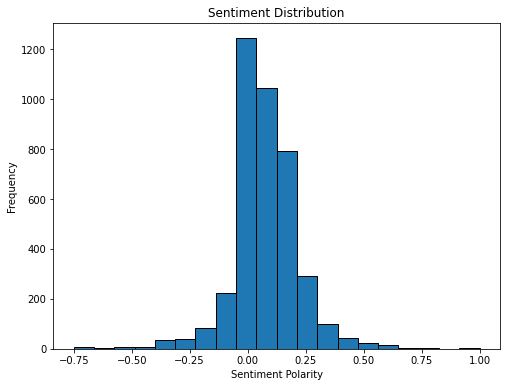

,Question,Response,target,word_count_q,word_count_r,char_count_q,char_count_r,Question_short,Response_short,idx
196,Can you provide a guide to starting a meditati...,*,6,10,1,58,1,Can you provide a guide to starting a meditati...,*,196
339,How do you manage to keep information concise ...,*,1,14,1,93,1,How do you manage to keep information concise ...,*,339
401,What safeguards are in place to prevent misuse...,*,0,13,1,81,1,What safeguards are in place to prevent misuse...,*,401
798,How do you ensure the safety of the informatio...,*,1,11,1,60,1,How do you ensure the safety of the informatio...,*,798
819,Who were the key figures in the spread of Budd...,* Siddhartha Gautama (Buddha): Founder of Budd...,1,10,186,51,1209,Who were the key figures in the spread of Budd...,* Siddhartha Gautama (Buddha): Founder of Budd...,819
1081,What might cause severe abdominal pain and blo...,"* Excessive intake of alcohol, tobacco, and ce...",5,9,48,59,312,What might cause severe abdominal pain and blo...,"* Excessive intake of alcohol, tobacco, and ce...",1081
1931,What word is spelled incorrectly in every sing...,"*Note that this riddle doesn't make sense, as ...",1,9,40,60,256,What word is spelled incorrectly in every sing...,"*Note that this riddle doesn't make sense, as ...",1931
2141,What are some tips for staying motivated when ...,* Identify your passion and purpose with the w...,5,12,77,67,450,What are some tips for staying motivated when ...,* Identify your passion and purpose with the w...,2141
2279,How can I improve my memory and recall abilities?,*,1,9,1,49,1,How can I improve my memory and recall abilities?,*,2279
2725,"Tires a horse, worries a man. Tell me this rid...",*,0,13,1,61,1,"Tires a horse, worries a man. Tell me this riddle",*,2725


,Question,Response,word_count_q,word_count_r
id,,,,
273,Which film features a character named Jack Ske...,*The Nightmare Before Christmas (1993)*\nJack ...,8,105
446,I have seven letters and am something you eat....,*,49,1
969,What was the impact of the fall of Constantino...,*,11,1
971,Can you create a short story based on a specif...,"**Title:** ""Melody's Mysterious Symphony""\n\n*...",11,417


In [18]:
def preprocess_text(text):
        words = word_tokenize(text)
        words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
        return words
def text_analysis(df_,col = 'Response'):
    df = df_.copy()

    # Basic summary of the text data
    print("Basic Summary:")
    print(df[[col]].describe())

    # Word Count
    df['Word Count'] = df[col].apply(lambda x: len(str(x).split()))

    # Character Count
    df['Character Count'] = df[col].apply(len)

    # Average Word Length
    df['Avg Word Length'] = df.apply(lambda row: row['Character Count'] / row['Word Count'] if row['Word Count']!=0 else row['Character Count'] / 1 , axis=1)

    # Most Common Words
    
    clean_words = preprocess_text(" ".join(df[col].to_list()))
    
    all_words = ' '.join(clean_words)
        
    word_freq = Counter(all_words.split())
    most_common_words = word_freq.most_common(10)
    print("Most Common Words:")
    for word, freq in most_common_words:
        print(f"{word}: {freq} times")

    # Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud")
    plt.show()

    # Sentiment Analysis
    df['Sentiment'] = df[col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # Visualize Sentiment Distribution
    plt.figure(figsize=(8, 6))
    df['Sentiment'].plot(kind='hist', bins=20, edgecolor='k')
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("Frequency")
    plt.show()
    print("")
text_analysis(train,col = 'Question')


text_analysis(train,col = 'Response')
display(train[(train['Question'].apply(lambda text : text.startswith("*")) | 
              (train['Response'].apply(lambda text : text.startswith("*"))))])
display(test[(test['Question'].apply(lambda text : text.startswith("*"))) | 
            (test['Response'].apply(lambda text : text.startswith("*")))])

In [19]:
train["question_and_response"] = train.Question + " " +train.Response
test["question_and_response"] = test.Question + " " +test.Response

In [20]:
np.random.seed(1)
def topic_analysis(df_,col = 'Response'):
    df = df_.copy()
    # Text preprocessing

    # Apply preprocessing to the "Response" column
    df[f'Tokenized_{col}'] = df[col].apply(preprocess_text)

    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(df[f'Tokenized_{col}'])
    corpus = [dictionary.doc2bow(text) for text in df[f'Tokenized_{col}']]

    # Perform LDA topic modeling
    lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15,random_state=1)

    # Print the topics
    print("")
    print(f"LDA Topics - {col}:")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx}: {topic}")

    # To assign topics to each response, you can use the following:
    df['Topic'] = df[f'Tokenized_{col}'].apply(lambda text: lda_model[dictionary.doc2bow(text)][0][0])

    # Print the topics assigned to each response
    print(f"Topics Assigned to {col}:")
    print(df[[col, 'Topic']])
    print("")
print("Train Data Topic Analysis")
topic_analysis(train,col = 'question_and_response')

Train Data Topic Analysis

LDA Topics - question_and_response:
Topic 0: 0.033*"data" + 0.009*"information" + 0.009*"the" + 0.008*"model" + 0.008*"learning" + 0.007*"used" + 0.006*"this" + 0.006*"process" + 0.005*"ai" + 0.005*"language"
Topic 1: 0.017*"i" + 0.008*"help" + 0.007*"this" + 0.006*"answer" + 0.006*"what" + 0.006*"time" + 0.006*"use" + 0.005*"question" + 0.005*"skills" + 0.005*"make"
Topic 2: 0.015*"the" + 0.012*"x" + 0.010*"this" + 0.010*"cell" + 0.009*"process" + 0.008*"cells" + 0.007*"dna" + 0.007*"behavior" + 0.006*"animals" + 0.006*"in"
Topic 3: 0.020*"the" + 0.008*"cause" + 0.007*"war" + 0.007*"symptoms" + 0.007*"pain" + 0.006*"it" + 0.006*"world" + 0.005*"what" + 0.005*"this" + 0.005*"also"
Topic 4: 0.014*"the" + 0.008*"this" + 0.006*"species" + 0.006*"one" + 0.006*"it" + 0.006*"what" + 0.005*"code" + 0.005*"in" + 0.005*"system" + 0.005*"different"
Topics Assigned to question_and_response:
                                  question_and_response  Topic
0     Explain the

In [21]:
print("Test Data Topic Analysis")
np.random.seed(1)
topic_analysis(test,col = 'question_and_response')

Test Data Topic Analysis

LDA Topics - question_and_response:
Topic 0: 0.011*"dna" + 0.011*"the" + 0.007*"testing" + 0.007*"information" + 0.007*"factory" + 0.007*"model" + 0.006*"i" + 0.006*"rna" + 0.005*"this" + 0.005*"specific"
Topic 1: 0.022*"the" + 0.011*"data" + 0.010*"war" + 0.007*"this" + 0.007*"learning" + 0.006*"world" + 0.006*"it" + 0.005*"what" + 0.005*"states" + 0.004*"one"
Topic 2: 0.009*"this" + 0.008*"data" + 0.007*"the" + 0.007*"system" + 0.006*"process" + 0.005*"encryption" + 0.005*"use" + 0.005*"key" + 0.005*"set" + 0.005*"code"
Topic 3: 0.012*"the" + 0.008*"symptoms" + 0.007*"pain" + 0.007*"cells" + 0.006*"cause" + 0.005*"dance" + 0.005*"what" + 0.005*"disease" + 0.005*"also" + 0.005*"this"
Topic 4: 0.009*"time" + 0.007*"help" + 0.007*"even" + 0.007*"i" + 0.007*"this" + 0.005*"the" + 0.005*"a" + 0.005*"like" + 0.004*"two" + 0.004*"what"
Topics Assigned to question_and_response:
                                  question_and_response  Topic
id                        

In [22]:
df = train.copy()
col = "Response"
# Text preprocessing

# Apply preprocessing to the "Response" column
df[f'Tokenized_{col}'] = df[col].apply(preprocess_text)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df[f'Tokenized_{col}'])
corpus = [dictionary.doc2bow(text) for text in df[f'Tokenized_{col}']]

top_num_word = 1000
# Count word frequencies in the corpus
word_freq = defaultdict(int)

# Concatenate all tokenized texts into one list of words
all_words = [word for text in df[f'Tokenized_{col}'] for word in text]

# Count the frequencies of each word
for word in all_words:
    word_freq[word] += 1

# Sort words by frequency in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)

# Take the top_num_word most common words
locals()["top_{top_num_word}_words"] = [word for word, freq in sorted_word_freq[:top_num_word]]
# print(locals()["top_{top_num_word}_words"])

# Load a pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


words_to_visualize = locals()["top_{top_num_word}_words"]
word_tokens = tokenizer(words_to_visualize, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    word_embeddings = model(**word_tokens);

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
